# Madness of March
## Jim Haines & Josh McCoy
### [Project Website](https://joshmccoy2.github.io/NCAA_March_Madness/)

## Current Datasets
[Kaggle datasets](https://www.kaggle.com/competitions/mens-march-mania-2022/data)

# ETL & EDA

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd 

# Elo Score

In [2]:
def update_elo(winner_rating, loser_rating):
    K = 20  # Maximum change per game
    expected_win = 1 / (1 + 10 ** ((loser_rating - winner_rating) / 400))
    new_winner_rating = winner_rating + K * (1 - expected_win)
    new_loser_rating = loser_rating - K * (1 - expected_win)
    return new_winner_rating, new_loser_rating


# Adding in Other Kaggle Data to run XG Boost On

In [3]:
detailed_results_data = 'MRegularSeasonDetailedResults.csv'
detailed_results = pd.read_csv(detailed_results_data)
detailed_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113236,2024,132,1120,86,1196,67,N,0,31,61,...,13,18,25,13,26,9,11,8,6,17
113237,2024,132,1182,57,1433,51,N,0,17,57,...,24,12,14,9,25,9,16,10,9,16
113238,2024,132,1228,93,1458,87,N,0,30,57,...,20,20,23,13,17,17,7,7,1,20
113239,2024,132,1412,85,1396,69,N,0,31,63,...,21,14,17,11,26,17,14,6,6,18


In [4]:
df_games = pd.read_csv('MRegularSeasonCompactResults.csv')
df_games_w = pd.read_csv('WRegularSeasonCompactResults.csv')
df_seeds = pd.read_csv('2024_tourney_seeds.csv')
df_seeds_MNCAA = pd.read_csv('MNCAATourneySeeds.csv')
round_slots = pd.read_csv('MNCAATourneySlots.csv')
round_slots_w = pd.read_csv('WNCAATourneySlots.csv')
mteams_df = pd.read_csv('MTeams.csv')

In [5]:
detailed_results.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object')

In [6]:
game_df = detailed_results[['Season', 'WTeamID', 'WScore', 'LTeamID', 'LScore']].copy()
game_df#.groupby('WTeamID')['WScore']

,Season,WTeamID,WScore,LTeamID,LScore
0,2003,1104,68,1328,62
1,2003,1272,70,1393,63
2,2003,1266,73,1437,61
3,2003,1296,56,1457,50
4,2003,1400,77,1208,71
...,...,...,...,...,...
113236,2024,1120,86,1196,67
113237,2024,1182,57,1433,51
113238,2024,1228,93,1458,87
113239,2024,1412,85,1396,69


In [7]:
#Create variable for amount by which winning team wins
# Create variable for amount by which winning team wins
detailed_results['SCOREDIFF'] = detailed_results['WScore'] - detailed_results['LScore']
# Winner stats
detailed_results.dtypes
detailed_results['WFGPCT'] = detailed_results['WFGM']/detailed_results['WFGA']       # field goal pt completion %
detailed_results['W3PCT'] = detailed_results['WFGM3']/detailed_results['WFGA3']      # 3 pt completion %
detailed_results['WFTPCT'] = detailed_results['WFTM']/detailed_results['WFTA']       # free throw completion %
detailed_results['WORBCHANCE'] =  detailed_results['WOR'] + detailed_results['LDR']  # total potential rebounds
detailed_results['WORPCT'] = detailed_results['WOR']/detailed_results['WORBCHANCE']  # rebound completion %
# Losing stats
detailed_results['LFGPCT'] = detailed_results['LFGM']/detailed_results['LFGA']       
detailed_results['L3PCT'] = detailed_results['LFGM3']/detailed_results['LFGA3']
detailed_results['LFTPCT'] = detailed_results['LFTM']/detailed_results['LFTA']
detailed_results['LORBCHANCE'] =  detailed_results['LOR'] + detailed_results['WDR']
detailed_results['LORPCT'] = detailed_results['LOR']/detailed_results['LORBCHANCE']

# Create a new data frame for winning teams
df_winning = detailed_results[['Season', 'DayNum', 'NumOT', 'SCOREDIFF'] + [col for col in detailed_results.columns if col.startswith('W')]].copy()
df_winning['Outcome'] = 1
df_winning['Outcome'] = df_winning['Outcome'].astype(int)


# Create a new data frame for losing teams
df_losing = detailed_results[['Season', 'DayNum', 'NumOT', 'SCOREDIFF'] + [col for col in detailed_results.columns if col.startswith('L')]].copy()
df_losing['Outcome'] = 0
df_losing['Outcome'] = df_losing['Outcome'].astype(int)

df_winning.head()
df_losing

,Season,DayNum,NumOT,SCOREDIFF,LTeamID,LScore,LFGM,LFGA,LFGM3,LFGA3,...,LTO,LStl,LBlk,LPF,LFGPCT,L3PCT,LFTPCT,LORBCHANCE,LORPCT,Outcome
0,2003,10,0,6,1328,62,22,53,2,10,...,18,9,2,20,0.415094,0.200000,0.727273,34,0.294118,0
1,2003,10,0,7,1393,63,24,67,6,24,...,12,8,6,16,0.358209,0.250000,0.450000,48,0.416667,0
2,2003,11,0,12,1437,61,22,73,3,26,...,12,2,5,23,0.301370,0.115385,0.608696,57,0.543860,0
3,2003,11,0,6,1457,50,18,49,6,22,...,19,4,3,23,0.367347,0.272727,0.533333,36,0.472222,0
4,2003,11,0,6,1208,71,24,62,6,16,...,10,7,1,14,0.387097,0.375000,0.629630,43,0.488372,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113236,2024,132,0,19,1196,67,24,66,1,13,...,11,8,6,17,0.363636,0.076923,0.720000,46,0.282609,0
113237,2024,132,0,6,1433,51,17,47,5,24,...,16,10,9,16,0.361702,0.208333,0.857143,32,0.281250,0
113238,2024,132,0,6,1458,87,30,64,7,20,...,7,7,1,20,0.468750,0.350000,0.869565,37,0.351351,0
113239,2024,132,0,16,1396,69,25,61,5,21,...,14,6,6,18,0.409836,0.238095,0.823529,38,0.289474,0


In [8]:
negative_count_W = (df_winning['SCOREDIFF'] < 0).sum()
negative_count_L = (df_losing['SCOREDIFF'] < 0).sum()


print("Number of negative negative_count_W values:", negative_count_W)
print("Number of negative negative_count_L values:", negative_count_L)

Number of negative negative_count_W values: 0
Number of negative negative_count_L values: 0


In [9]:
df_losing.columns

Index(['Season', 'DayNum', 'NumOT', 'SCOREDIFF', 'LTeamID', 'LScore', 'LFGM',
       'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO',
       'LStl', 'LBlk', 'LPF', 'LFGPCT', 'L3PCT', 'LFTPCT', 'LORBCHANCE',
       'LORPCT', 'Outcome'],
      dtype='object')

### Averages for Losing Team ID

In [10]:
# Grouping the DataFrame by 'Season' and 'LTeamID' and calculating the average
l_averages_df = df_losing.groupby(['Season', 'LTeamID']).agg({
    'LScore': 'mean',
    'LFGM': 'mean',
    'LFGA': 'mean',
    'LFGM3': 'mean',
    'LFGA3': 'mean',
    'LFTM': 'mean',
    'LFTA': 'mean',
    'LOR': 'mean',
    'LDR': 'mean',
    'LAst': 'mean',
    'LTO': 'mean',
    'LStl': 'mean',
    'LBlk': 'mean',
    'LPF': 'mean',
    'LFGPCT': 'mean',
    'L3PCT': 'mean',
    'LFTPCT': 'mean',
    'LORBCHANCE': 'mean',
    'LORPCT': 'mean',
    'SCOREDIFF': 'mean'
}).reset_index()

# Renaming columns to reflect they are averages
l_averages_df.columns = ['Season', 'LTeamID', 'average_LScore', 'average_LFGM', 'average_LFGA', 'average_LFGM3',
                       'average_LFGA3', 'average_LFTM', 'average_LFTA', 'average_LOR', 'average_LDR',
                       'average_LAst', 'average_LTO', 'average_LStl', 'average_LBlk', 'average_LPF',
                       'average_LFGPCT', 'average_L3PCT', 'average_LFTPCT', 'average_LORBCHANCE',
                       'average_LORPCT', 'average_SCOREDIFF']

# Displaying the resulting DataFrame
l_averages_df.head(5)

,Season,LTeamID,average_LScore,average_LFGM,average_LFGA,average_LFGM3,average_LFGA3,average_LFTM,average_LFTA,average_LOR,...,average_LTO,average_LStl,average_LBlk,average_LPF,average_LFGPCT,average_L3PCT,average_LFTPCT,average_LORBCHANCE,average_LORPCT,average_SCOREDIFF
0,2003,1102,48.625000,16.562500,39.625000,6.187500,20.250000,9.312500,14.375000,4.437500,...,11.687500,4.937500,1.000000,20.750000,0.424810,0.305953,0.650437,26.187500,0.165271,11.250000
1,2003,1103,70.428571,24.500000,56.285714,5.428571,17.642857,16.000000,21.142857,10.142857,...,12.714286,7.214286,2.785714,19.285714,0.435972,0.303355,0.747034,34.000000,0.294003,7.500000
2,2003,1104,60.909091,21.272727,55.363636,5.272727,18.363636,13.090909,18.454545,13.636364,...,13.636364,5.636364,3.181818,20.454545,0.381478,0.291478,0.698651,35.909091,0.377756,9.454545
3,2003,1105,68.947368,23.947368,61.526316,7.000000,20.157895,14.052632,20.421053,13.105263,...,18.894737,8.578947,2.105263,20.526316,0.389832,0.347824,0.697004,40.526316,0.317489,11.473684
4,2003,1106,59.533333,22.266667,56.533333,6.333333,19.133333,8.666667,12.733333,11.866667,...,16.466667,7.466667,2.600000,18.000000,0.394117,0.321348,0.650908,36.600000,0.323938,9.266667


### Averages for Winning Teams ID 

In [11]:
# Grouping the DataFrame by 'Season' and 'LTeamID' and calculating the average
w_averages_df = df_winning.groupby(['Season', 'WTeamID']).agg({
    'WScore': 'mean',
    'WFGM': 'mean',
    'WFGA': 'mean',
    'WFGM3': 'mean',
    'WFGA3': 'mean',
    'WFTM': 'mean',
    'WFTA': 'mean',
    'WOR': 'mean',
    'WDR': 'mean',
    'WAst': 'mean',
    'WTO': 'mean',
    'WStl': 'mean',
    'WBlk': 'mean',
    'WPF': 'mean',
    'WFGPCT': 'mean',
    'W3PCT': 'mean',
    'WFTPCT': 'mean',
    'WORBCHANCE': 'mean',
    'WORPCT': 'mean',
    'SCOREDIFF': 'mean'
}).reset_index()

# Renaming columns to reflect they are averages
w_averages_df.columns = ['Season', 'WTeamID', 'average_WScore', 'average_WFGM', 'average_WFGA', 'average_WFGM3',
                       'average_WFGA3', 'average_WFTM', 'average_WFTA', 'average_WOR', 'average_WDR',
                       'average_WAst', 'average_WTO', 'average_WStl', 'average_WBlk', 'average_WPF',
                       'average_WFGPCT', 'average_W3PCT', 'average_WFTPCT', 'average_WORBCHANCE',
                       'average_WORPCT', 'average_SCOREDIFF']

# Displaying the resulting DataFrame
w_averages_df.head(5)

,Season,WTeamID,average_WScore,average_WFGM,average_WFGA,average_WFGM3,average_WFGA3,average_WFTM,average_WFTA,average_WOR,...,average_WTO,average_WStl,average_WBlk,average_WPF,average_WFGPCT,average_W3PCT,average_WFTPCT,average_WORBCHANCE,average_WORPCT,average_SCOREDIFF
0,2003,1102,68.750000,22.583333,40.000000,10.000000,21.583333,13.583333,20.750000,3.833333,...,11.083333,7.333333,2.833333,16.083333,0.567934,0.449882,0.631688,21.833333,0.172188,15.583333
1,2003,1103,87.769231,30.000000,55.384615,5.461538,14.384615,22.307692,30.923077,9.384615,...,12.538462,7.307692,1.846154,20.461538,0.542563,0.362828,0.722603,29.461538,0.318510,9.384615
2,2003,1104,74.705882,25.823529,58.352941,7.058824,20.823529,16.000000,22.529412,13.529412,...,13.058824,7.235294,4.176471,16.470588,0.444393,0.347418,0.709384,36.411765,0.367049,13.176471
3,2003,1105,79.428571,25.571429,61.857143,9.142857,22.428571,19.142857,25.714286,14.571429,...,18.000000,11.285714,2.000000,19.428571,0.413500,0.391674,0.743782,38.142857,0.383144,13.000000
4,2003,1106,68.307692,24.769231,53.846154,5.846154,15.923077,12.923077,20.769231,12.769231,...,17.692308,9.384615,3.769231,18.384615,0.461775,0.383482,0.591138,32.384615,0.378952,10.384615


## Renaming Columns to merge average stats together

In [12]:
l_averages_df.rename(columns={'LTeamID': 'TeamID'}, inplace=True)
w_averages_df.rename(columns={'WTeamID': 'TeamID'}, inplace=True)
average_merged_df = w_averages_df.merge(l_averages_df, on=['TeamID', 'Season'], how='left')
average_merged_df.columns

Index(['Season', 'TeamID', 'average_WScore', 'average_WFGM', 'average_WFGA',
       'average_WFGM3', 'average_WFGA3', 'average_WFTM', 'average_WFTA',
       'average_WOR', 'average_WDR', 'average_WAst', 'average_WTO',
       'average_WStl', 'average_WBlk', 'average_WPF', 'average_WFGPCT',
       'average_W3PCT', 'average_WFTPCT', 'average_WORBCHANCE',
       'average_WORPCT', 'average_SCOREDIFF_x', 'average_LScore',
       'average_LFGM', 'average_LFGA', 'average_LFGM3', 'average_LFGA3',
       'average_LFTM', 'average_LFTA', 'average_LOR', 'average_LDR',
       'average_LAst', 'average_LTO', 'average_LStl', 'average_LBlk',
       'average_LPF', 'average_LFGPCT', 'average_L3PCT', 'average_LFTPCT',
       'average_LORBCHANCE', 'average_LORPCT', 'average_SCOREDIFF_y'],
      dtype='object')

In [13]:
negative_count_x = (average_merged_df['average_SCOREDIFF_x'] < 0).sum()
negative_count_y = (average_merged_df['average_SCOREDIFF_y'] < 0).sum()


print("Number of negative average_SCOREDIFF_x values:", negative_count_x)
print("Number of negative average_SCOREDIFF_y values:", negative_count_y)

Number of negative average_SCOREDIFF_x values: 0
Number of negative average_SCOREDIFF_y values: 0


In [14]:
# Iterate over the list of columns and calculate the average
for column in average_merged_df.columns:
    if column.startswith('average_W'):
        # Extract the corresponding 'L' column name
        l_column_name = column.replace('average_W', 'average_L')
        
        # Calculate the average and assign it to a new column
        new_column_name = column.replace('average_W', 'average')
        average_merged_df[new_column_name] = (average_merged_df[column] + average_merged_df[l_column_name]) / 2

# Drop the original 'W' 'L' columns
w_columns_to_drop = [col for col in average_merged_df.columns if col.startswith('average_W')]
l_columns_to_drop = [col for col in average_merged_df.columns if col.startswith('average_L')]
columns_to_drop = w_columns_to_drop + l_columns_to_drop
average_merged_df.drop(columns=columns_to_drop, inplace=True)
average_merged_df['average_SCOREDIFF'] = (average_merged_df['average_SCOREDIFF_x'] + average_merged_df['average_SCOREDIFF_y']) / 2
# Drop 'average_SCOREDIFF_x' and 'average_SCOREDIFF_y' columns
average_merged_df.drop(columns=['average_SCOREDIFF_x', 'average_SCOREDIFF_y'], inplace=True)
average_merged_df


,Season,TeamID,averageScore,averageFGM,averageFGA,averageFGM3,averageFGA3,averageFTM,averageFTA,averageOR,...,averageTO,averageStl,averageBlk,averagePF,averageFGPCT,average3PCT,averageFTPCT,averageORBCHANCE,averageORPCT,average_SCOREDIFF
0,2003,1102,58.687500,19.572917,39.812500,8.093750,20.916667,11.447917,17.562500,4.135417,...,11.385417,6.135417,1.916667,18.416667,0.496372,0.377918,0.641063,24.010417,0.168729,13.416667
1,2003,1103,79.098901,27.250000,55.835165,5.445055,16.013736,19.153846,26.032967,9.763736,...,12.626374,7.260989,2.315934,19.873626,0.489268,0.333091,0.734818,31.730769,0.306256,8.442308
2,2003,1104,67.807487,23.548128,56.858289,6.165775,19.593583,14.545455,20.491979,13.582888,...,13.347594,6.435829,3.679144,18.462567,0.412936,0.319448,0.704018,36.160428,0.372403,11.315508
3,2003,1105,74.187970,24.759398,61.691729,8.071429,21.293233,16.597744,23.067669,13.838346,...,18.447368,9.932331,2.052632,19.977444,0.401666,0.369749,0.720393,39.334586,0.350317,12.236842
4,2003,1106,63.920513,23.517949,55.189744,6.089744,17.528205,10.794872,16.751282,12.317949,...,17.079487,8.425641,3.184615,18.192308,0.427946,0.352415,0.621023,34.492308,0.351445,9.825641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7604,2024,1474,78.322368,27.096491,62.390351,8.618421,25.528509,15.510965,21.528509,8.480263,...,11.019737,6.695175,2.747807,17.506579,0.436011,0.337942,0.715889,34.175439,0.242721,11.359649
7605,2024,1475,70.520833,22.941667,53.512500,7.141667,19.675000,17.495833,23.300000,7.975000,...,12.420833,5.845833,2.300000,20.820833,0.434243,0.370589,0.752429,30.187500,0.261532,9.687500
7606,2024,1476,64.740741,23.111111,53.666667,8.111111,24.444444,10.407407,15.574074,6.185185,...,11.648148,5.407407,2.648148,15.111111,0.438255,0.341948,0.670147,30.425926,0.195134,13.703704
7607,2024,1477,70.675000,24.250000,60.000000,8.575000,27.400000,13.600000,19.625000,7.525000,...,10.600000,7.400000,4.725000,17.575000,0.404911,0.310385,0.703995,34.675000,0.214094,12.100000


In [15]:
average_merged_df.columns

Index(['Season', 'TeamID', 'averageScore', 'averageFGM', 'averageFGA',
       'averageFGM3', 'averageFGA3', 'averageFTM', 'averageFTA', 'averageOR',
       'averageDR', 'averageAst', 'averageTO', 'averageStl', 'averageBlk',
       'averagePF', 'averageFGPCT', 'average3PCT', 'averageFTPCT',
       'averageORBCHANCE', 'averageORPCT', 'average_SCOREDIFF'],
      dtype='object')

In [16]:
negative_count = (average_merged_df['average_SCOREDIFF'] < 0).sum()

print("Number of negative average_SCOREDIFF values:", negative_count)

Number of negative average_SCOREDIFF values: 0


# Jim Read THIS below

### Ok so now we have the season averages for each team from seasons 2003 - 2023... now we need to create an XGBoost model for each one of these... we also need to see who they are playing... so what im thinking for XG Boost is have teamID_1 and TeamID_2 dataframe structure kind of how he does it below in Predicting Winner... and then we will feed the XGBoost model two different dfs to keep it clean

# Bring in the tournament dataframes so we know who is playing who 

In [17]:
import numpy as np

# Check for missing values
missing_values_sum = average_merged_df['average_SCOREDIFF'].isnull().sum()
print("Number of missing values:", missing_values_sum)

# Check for infinite values
infinite_values = np.isinf(average_merged_df['average_SCOREDIFF']).sum()
print("Number of infinite values:", infinite_values)


Number of missing values: 3
Number of infinite values: 0


In [18]:
missing_values = average_merged_df['average_SCOREDIFF'].isnull()

# Boolean indexing to locate missing values
missing_data = average_merged_df[missing_values]

print("Missing values:")
print(missing_values)

Missing values:
0       False
1       False
2       False
3       False
4       False
        ...  
7604    False
7605    False
7606    False
7607    False
7608    False
Name: average_SCOREDIFF, Length: 7609, dtype: bool


In [19]:
true_indices = missing_values.index[missing_values]
print("Indices where values are True:")
print(true_indices)

Indices where values are True:
Index([4064, 4211, 6280], dtype='int64')


In [20]:
average_merged_df.iloc[4064]

Season               2014.0
TeamID               1455.0
averageScore            NaN
averageFGM              NaN
averageFGA              NaN
averageFGM3             NaN
averageFGA3             NaN
averageFTM              NaN
averageFTA              NaN
averageOR               NaN
averageDR               NaN
averageAst              NaN
averageTO               NaN
averageStl              NaN
averageBlk              NaN
averagePF               NaN
averageFGPCT            NaN
average3PCT             NaN
averageFTPCT            NaN
averageORBCHANCE        NaN
averageORPCT            NaN
average_SCOREDIFF       NaN
Name: 4064, dtype: float64

In [21]:


# Assuming your DataFrame is named df
# Group by 'Season' and compute the mean of each column within each group
season_means = average_merged_df.groupby('Season').mean()

# Fill NaN values in each column with the corresponding mean value from the group
df_imputed = average_merged_df.fillna(average_merged_df.groupby('Season').transform('mean'))

# Reset index
df_imputed.reset_index(drop=True, inplace=True)

# Display the DataFrame with imputed NaN values
df_imputed.iloc[4064]


Season               2014.000000
TeamID               1455.000000
averageScore           70.291826
averageFGM             24.178753
averageFGA             55.137125
averageFGM3             6.245653
averageFGA3            18.124254
averageFTM             15.688666
averageFTA             22.453083
averageOR              10.822786
averageDR              23.656508
averageAst             12.480603
averageTO              12.375591
averageStl              6.042998
averageBlk              3.565404
averagePF              19.326209
averageFGPCT            0.440625
average3PCT             0.343652
averageFTPCT            0.694969
averageORBCHANCE       34.494400
averageORPCT            0.310534
average_SCOREDIFF      10.984258
Name: 4064, dtype: float64

In [22]:
# Filter rows where Season is 2023
df_22 = df_imputed[df_imputed['Season'] == 2022].copy()
df_22

,Season,TeamID,averageScore,averageFGM,averageFGA,averageFGM3,averageFGA3,averageFTM,averageFTA,averageOR,...,averageTO,averageStl,averageBlk,averagePF,averageFGPCT,average3PCT,averageFTPCT,averageORBCHANCE,averageORPCT,average_SCOREDIFF
6528,2022,1101,71.094737,24.181579,58.660526,6.550000,21.497368,16.181579,21.694737,8.578947,...,12.071053,9.868421,1.718421,22.265789,0.411675,0.303518,0.735331,34.076316,0.246518,10.805263
6529,2022,1102,60.017677,21.924242,49.515152,7.351010,21.727273,8.818182,13.487374,4.934343,...,11.775253,5.679293,3.222222,17.939394,0.444263,0.335400,0.656686,28.085859,0.174458,11.863636
6530,2022,1103,66.282828,22.851010,52.699495,7.237374,22.265152,13.343434,20.032828,8.040404,...,10.722222,5.308081,3.068182,16.436869,0.436854,0.329868,0.651488,29.863636,0.272848,8.936869
6531,2022,1104,79.244939,27.370445,62.850202,9.248988,30.309717,15.255061,20.943320,11.684211,...,14.115385,6.987854,4.605263,18.840081,0.437117,0.307873,0.725893,34.777328,0.336010,9.542510
6532,2022,1105,63.194444,22.291667,57.611111,3.902778,14.069444,14.708333,20.486111,9.583333,...,12.958333,6.708333,3.305556,15.694444,0.390806,0.284893,0.713868,34.541667,0.277244,11.305556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6879,2022,1468,67.262019,25.206731,55.151442,7.790865,23.158654,9.057692,12.074519,6.161058,...,8.954327,5.086538,1.375000,15.218750,0.458589,0.336506,0.754734,28.822115,0.209930,12.459135
6880,2022,1469,70.444444,24.861111,59.083333,6.888889,22.055556,13.833333,20.555556,8.583333,...,14.305556,5.944444,2.472222,19.527778,0.421351,0.307863,0.672327,34.611111,0.243269,13.166667
6881,2022,1470,64.449198,22.596257,53.411765,5.435829,16.874332,13.820856,18.414439,7.526738,...,9.949198,7.254011,2.136364,17.812834,0.425145,0.316151,0.742189,30.254011,0.249777,11.863636
6882,2022,1471,70.045455,23.647727,52.948864,8.982955,24.215909,13.767045,18.224432,4.653409,...,12.360795,5.326705,1.857955,15.039773,0.449272,0.373282,0.748336,28.951705,0.160544,11.264205


In [23]:
df_23 = df_imputed[df_imputed['Season'] == 2023].copy()
df_23

,Season,TeamID,averageScore,averageFGM,averageFGA,averageFGM3,averageFGA3,averageFTM,averageFTA,averageOR,...,averageTO,averageStl,averageBlk,averagePF,averageFGPCT,average3PCT,averageFTPCT,averageORBCHANCE,averageORPCT,average_SCOREDIFF
6884,2023,1101,72.977124,25.816993,57.532680,6.895425,19.016340,14.447712,19.640523,7.444444,...,11.725490,7.944444,1.944444,20.467320,0.450873,0.355328,0.716842,31.803922,0.236536,11.490196
6885,2023,1102,67.841270,23.896825,51.119048,8.226190,22.805556,11.821429,16.345238,5.722222,...,10.765873,5.865079,4.031746,16.849206,0.468631,0.360307,0.717457,27.698413,0.210309,11.349206
6886,2023,1103,72.202273,24.665909,57.350000,8.420455,24.781818,14.450000,19.331818,8.463636,...,11.222727,5.640909,2.515909,16.579545,0.430816,0.343510,0.733668,30.456818,0.277581,13.402273
6887,2023,1104,76.806897,25.875862,60.382759,8.875862,27.627586,16.179310,21.755172,10.824138,...,15.331034,5.455172,4.537931,19.603448,0.429010,0.322951,0.750137,34.844828,0.304062,15.520690
6888,2023,1105,68.430556,24.444444,56.041667,6.402778,18.111111,13.138889,20.319444,8.694444,...,13.708333,7.555556,4.069444,18.875000,0.439788,0.349111,0.644607,30.625000,0.285612,10.402778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7242,2023,1473,72.458333,25.729167,57.428571,8.151786,20.455357,12.848214,17.047619,6.880952,...,12.889881,6.005952,3.479167,16.750000,0.447311,0.399306,0.743420,31.300595,0.220035,11.357143
7243,2023,1474,75.633333,25.666667,58.933333,9.033333,25.966667,15.266667,21.133333,9.266667,...,11.900000,5.933333,2.266667,16.133333,0.435535,0.346473,0.718531,33.233333,0.278104,7.166667
7244,2023,1475,76.254808,26.228365,61.187500,9.629808,26.036058,14.168269,20.867788,10.435096,...,12.413462,6.673077,2.286058,18.442308,0.430844,0.368700,0.672948,34.187500,0.303709,9.557692
7245,2023,1476,66.678733,23.047511,52.319005,7.533937,21.540724,13.049774,17.099548,5.006787,...,12.687783,6.943439,2.871041,15.027149,0.438491,0.347646,0.742237,29.176471,0.167994,9.669683


In [24]:
df_24 = df_imputed[df_imputed['Season'] == 2024].copy()
df_24

,Season,TeamID,averageScore,averageFGM,averageFGA,averageFGM3,averageFGA3,averageFTM,averageFTA,averageOR,...,averageTO,averageStl,averageBlk,averagePF,averageFGPCT,average3PCT,averageFTPCT,averageORBCHANCE,averageORPCT,average_SCOREDIFF
7247,2024,1101,71.424370,24.850840,57.981092,5.090336,14.716387,16.632353,22.567227,7.760504,...,12.094538,7.886555,2.113445,19.649160,0.431314,0.348841,0.740826,33.342437,0.234262,9.445378
7248,2024,1102,68.477273,24.106061,52.244949,8.994949,24.361111,11.270202,16.376263,6.229798,...,10.424242,6.790404,4.315657,17.219697,0.460484,0.368758,0.687598,27.916667,0.221374,12.974747
7249,2024,1103,70.450000,24.809091,55.459091,7.254545,23.104545,13.577273,18.627273,7.972727,...,11.000000,5.168182,2.827273,17.004545,0.446565,0.319053,0.735653,30.013636,0.262791,8.677273
7250,2024,1104,88.536797,30.106061,64.549784,10.376623,30.041126,17.948052,23.095238,10.915584,...,12.008658,6.735931,3.787879,20.965368,0.468108,0.342506,0.771090,33.512987,0.324385,17.077922
7251,2024,1105,69.363636,22.954545,54.500000,4.204545,14.522727,19.250000,26.568182,9.659091,...,14.977273,7.681818,4.000000,20.454545,0.423166,0.289944,0.719939,31.772727,0.304636,11.795455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7604,2024,1474,78.322368,27.096491,62.390351,8.618421,25.528509,15.510965,21.528509,8.480263,...,11.019737,6.695175,2.747807,17.506579,0.436011,0.337942,0.715889,34.175439,0.242721,11.359649
7605,2024,1475,70.520833,22.941667,53.512500,7.141667,19.675000,17.495833,23.300000,7.975000,...,12.420833,5.845833,2.300000,20.820833,0.434243,0.370589,0.752429,30.187500,0.261532,9.687500
7606,2024,1476,64.740741,23.111111,53.666667,8.111111,24.444444,10.407407,15.574074,6.185185,...,11.648148,5.407407,2.648148,15.111111,0.438255,0.341948,0.670147,30.425926,0.195134,13.703704
7607,2024,1477,70.675000,24.250000,60.000000,8.575000,27.400000,13.600000,19.625000,7.525000,...,10.600000,7.400000,4.725000,17.575000,0.404911,0.310385,0.703995,34.675000,0.214094,12.100000


In [25]:
# # Convert the predicted values to a DataFrame
# predictions_df = pd.DataFrame({'Actual_Outcome': y_test, 'Predicted_Outcome': y_pred})

# # Display the predictions
# print(predictions_df)

In [26]:
# Count the number of negative values in the 'average_SCOREDIFF' column
negative_count = (df_imputed['average_SCOREDIFF'] < 0).sum()

print("Number of negative average_SCOREDIFF values:", negative_count)


Number of negative average_SCOREDIFF values: 0


## Create the XG Boost Model here... feed it two dfs I think so it can say "ok this team is playing this team and here are the average season stats for each" (team1_id team_2 id)

In [27]:
# For XGBoost 

# Predicting Winner 

In [28]:
# def predict_winner(team1_id, team2_id, elo_df):
#     elo1 = elo_df.loc[elo_df['TeamID'] == team1_id, 'EloRating'].iloc[0]
#     elo2 = elo_df.loc[elo_df['TeamID'] == team2_id, 'EloRating'].iloc[0]
#     return team1_id if elo1 > elo2 else team2_id

# for our purposes, predict winner needs to return ID of team we thing will win

# Simulate Tourney

# Elo with Seeds Merge

# Prepare Submission Data

In [29]:
df_games

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0
...,...,...,...,...,...,...,...,...
187284,2024,132,1120,86,1196,67,N,0
187285,2024,132,1182,57,1433,51,N,0
187286,2024,132,1228,93,1458,87,N,0
187287,2024,132,1412,85,1396,69,N,0


In [30]:
df_games_24 = df_games[df_games['Season'] == 2024]
df_games_24

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
181682,2024,0,1101,64,1329,59,A,0
181683,2024,0,1103,81,1355,75,A,0
181684,2024,0,1104,105,1287,73,H,0
181685,2024,0,1112,122,1288,59,H,0
181686,2024,0,1114,71,1402,66,H,0
...,...,...,...,...,...,...,...,...
187284,2024,132,1120,86,1196,67,N,0
187285,2024,132,1182,57,1433,51,N,0
187286,2024,132,1228,93,1458,87,N,0
187287,2024,132,1412,85,1396,69,N,0


In [31]:
round_slots = round_slots.loc[(round_slots['Season'] == 2023) & (round_slots['Slot'].str.startswith('R'))]
round_slots_w = round_slots_w.loc[(round_slots_w['Season'] == 2023) & (round_slots_w['Slot'].str.startswith('R'))]

In [32]:
round_slots

,Season,Slot,StrongSeed,WeakSeed
2385,2023,R1W1,W01,W16
2386,2023,R1W2,W02,W15
2387,2023,R1W3,W03,W14
2388,2023,R1W4,W04,W13
2389,2023,R1W5,W05,W12
...,...,...,...,...
2443,2023,R4Y1,R3Y1,R3Y2
2444,2023,R4Z1,R3Z1,R3Z2
2445,2023,R5WX,R4W1,R4X1
2446,2023,R5YZ,R4Y1,R4Z1


In [33]:
import pandas as pd

# Step 1: Merge df_games with df_24 for the winning and losing teams separately
merged_df_winning = pd.merge(df_games_24, df_24, left_on=['WTeamID', 'Season'], right_on=['TeamID', 'Season'], how='left')
merged_df_losing = pd.merge(df_games_24, df_24, left_on=['LTeamID', 'Season'], right_on=['TeamID', 'Season'], how='left')

# Step 2: Rename columns to distinguish between average stats of winning and losing teams
merged_df_winning.rename(columns=lambda x: x + '_W' if x not in ['Season', 'WTeamID', 'WScore'] else x, inplace=True)
merged_df_losing.rename(columns=lambda x: x + '_L' if x not in ['Season', 'LTeamID', 'LScore'] else x, inplace=True)

# Step 3: Concatenate the two merged DataFrames horizontally
final_df = pd.concat([merged_df_winning, merged_df_losing.drop(columns=['Season', 'WTeamID_L', 'WScore_L', 'TeamID_L'])], axis=1)

# Drop unnecessary columns
final_df.drop(columns=['LTeamID_W', 'LScore_W','WLoc_L','DayNum_L'], inplace=True)

# Display the resulting DataFrame
final_df.columns

Index(['Season', 'DayNum_W', 'WTeamID', 'WScore', 'WLoc_W', 'NumOT_W',
       'TeamID_W', 'averageScore_W', 'averageFGM_W', 'averageFGA_W',
       'averageFGM3_W', 'averageFGA3_W', 'averageFTM_W', 'averageFTA_W',
       'averageOR_W', 'averageDR_W', 'averageAst_W', 'averageTO_W',
       'averageStl_W', 'averageBlk_W', 'averagePF_W', 'averageFGPCT_W',
       'average3PCT_W', 'averageFTPCT_W', 'averageORBCHANCE_W',
       'averageORPCT_W', 'average_SCOREDIFF_W', 'LTeamID', 'LScore', 'NumOT_L',
       'averageScore_L', 'averageFGM_L', 'averageFGA_L', 'averageFGM3_L',
       'averageFGA3_L', 'averageFTM_L', 'averageFTA_L', 'averageOR_L',
       'averageDR_L', 'averageAst_L', 'averageTO_L', 'averageStl_L',
       'averageBlk_L', 'averagePF_L', 'averageFGPCT_L', 'average3PCT_L',
       'averageFTPCT_L', 'averageORBCHANCE_L', 'averageORPCT_L',
       'average_SCOREDIFF_L'],
      dtype='object')

In [34]:
final_df = final_df.drop(final_df.columns[6], axis=1)
final_df.columns

Index(['Season', 'DayNum_W', 'WTeamID', 'WScore', 'WLoc_W', 'NumOT_W',
       'averageScore_W', 'averageFGM_W', 'averageFGA_W', 'averageFGM3_W',
       'averageFGA3_W', 'averageFTM_W', 'averageFTA_W', 'averageOR_W',
       'averageDR_W', 'averageAst_W', 'averageTO_W', 'averageStl_W',
       'averageBlk_W', 'averagePF_W', 'averageFGPCT_W', 'average3PCT_W',
       'averageFTPCT_W', 'averageORBCHANCE_W', 'averageORPCT_W',
       'average_SCOREDIFF_W', 'LTeamID', 'LScore', 'NumOT_L', 'averageScore_L',
       'averageFGM_L', 'averageFGA_L', 'averageFGM3_L', 'averageFGA3_L',
       'averageFTM_L', 'averageFTA_L', 'averageOR_L', 'averageDR_L',
       'averageAst_L', 'averageTO_L', 'averageStl_L', 'averageBlk_L',
       'averagePF_L', 'averageFGPCT_L', 'average3PCT_L', 'averageFTPCT_L',
       'averageORBCHANCE_L', 'averageORPCT_L', 'average_SCOREDIFF_L'],
      dtype='object')

In [35]:
final_df['winner'] = final_df.apply(lambda x: 'W' if x['WScore'] > x['LScore'] else 'L', axis=1)

# Create the outcome column
final_df['outcome'] = final_df['winner'].apply(lambda x: 1 if x == 'W' else 0)

# Drop unnecessary columns
final_df.drop(['winner'], axis=1, inplace=True)
final_df

,Season,DayNum_W,WTeamID,WScore,WLoc_W,NumOT_W,averageScore_W,averageFGM_W,averageFGA_W,averageFGM3_W,...,averageStl_L,averageBlk_L,averagePF_L,averageFGPCT_L,average3PCT_L,averageFTPCT_L,averageORBCHANCE_L,averageORPCT_L,average_SCOREDIFF_L,outcome
0,2024,0,1101,64,A,0,71.424370,24.850840,57.981092,5.090336,...,6.341667,2.950000,15.591667,0.451927,0.344261,0.708241,30.250000,0.254239,12.575000,1
1,2024,0,1103,81,A,0,70.450000,24.809091,55.459091,7.254545,...,5.901316,3.092105,15.098684,0.475486,0.359968,0.711235,31.013158,0.219667,10.432018,1
2,2024,0,1104,105,H,0,88.536797,30.106061,64.549784,10.376623,...,5.431818,4.409091,17.948864,0.446289,0.332283,0.728393,30.039773,0.278717,14.244318,1
3,2024,0,1112,122,H,0,83.922500,30.085000,64.340000,7.115000,...,6.412500,3.375000,20.262500,0.446238,0.262599,0.744138,31.637500,0.286134,12.550000,1
4,2024,0,1114,71,H,0,76.732143,27.714286,60.101190,6.428571,...,7.350000,3.255556,17.972222,0.436952,0.320071,0.693447,31.400000,0.279039,11.400000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5602,2024,132,1120,86,N,0,78.230159,27.145503,60.677249,7.119048,...,6.602273,5.244318,18.545455,0.447934,0.325002,0.727345,36.083333,0.356421,10.712121,1
5603,2024,132,1182,57,N,0,68.952569,24.249012,56.766798,7.503953,...,6.190559,4.437063,16.723776,0.436435,0.356301,0.773182,29.708042,0.265156,9.409091,1
5604,2024,132,1228,93,N,0,81.975962,27.980769,62.504808,8.427885,...,6.103147,1.571678,16.907343,0.458316,0.342665,0.758826,31.197552,0.282833,11.410839,1
5605,2024,132,1412,85,N,0,76.068182,26.386364,59.659091,6.181818,...,7.358333,2.925000,17.025000,0.396463,0.321299,0.706582,36.216667,0.250057,8.875000,1


In [36]:
final_df['outcome'] = 1

# Now, merge the dataframe with itself to create entries for the losing team
losing_teams = final_df.rename(columns={'WTeamID': 'LTeamID', 'LTeamID': 'WTeamID', 'outcome': 'temp'}).drop(columns='temp')
losing_teams['outcome'] = 0

# Concatenate the original dataframe and the losing teams dataframe
df_duplicated = pd.concat([final_df, losing_teams], ignore_index=True)
df_duplicated.dtypes



Season                   int64
DayNum_W                 int64
WTeamID                  int64
WScore                   int64
WLoc_W                  object
NumOT_W                  int64
averageScore_W         float64
averageFGM_W           float64
averageFGA_W           float64
averageFGM3_W          float64
averageFGA3_W          float64
averageFTM_W           float64
averageFTA_W           float64
averageOR_W            float64
averageDR_W            float64
averageAst_W           float64
averageTO_W            float64
averageStl_W           float64
averageBlk_W           float64
averagePF_W            float64
averageFGPCT_W         float64
average3PCT_W          float64
averageFTPCT_W         float64
averageORBCHANCE_W     float64
averageORPCT_W         float64
average_SCOREDIFF_W    float64
LTeamID                  int64
LScore                   int64
NumOT_L                  int64
averageScore_L         float64
averageFGM_L           float64
averageFGA_L           float64
averageF

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Load the dataframe
df = df_duplicated.copy()

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode 'T1_TeamSeed' and 'T2_TeamSeed' columns
#df['T1_TeamSeedCorr'] = label_encoder.fit_transform(df['T1_TeamSeedCorr'])
#df['T2_TeamSeedCorr'] = label_encoder.fit_transform(df['T2_TeamSeedCorr'])

# Select features
selected_features = [ 'WTeamID', 'NumOT_W',
       'averageFGA_W', 'averageFGM3_W', 'averageFGA3_W', 'averageFTM_W',
       'averageFTA_W', 'averageOR_W', 'averageDR_W', 'averageAst_W',
       'averageTO_W', 'averageStl_W', 'averageBlk_W', 'averagePF_W',
       'averageFGPCT_W', 'average3PCT_W', 'averageFTPCT_W',
       'averageORBCHANCE_W', 'averageORPCT_W', 'average_SCOREDIFF_W',
       'LTeamID', 'NumOT_L', 'averageScore_L', 'averageFGM_L',
       'averageFGA_L', 'averageFGM3_L', 'averageFGA3_L', 'averageFTM_L',
       'averageFTA_L', 'averageOR_L', 'averageDR_L', 'averageAst_L',
       'averageTO_L', 'averageStl_L', 'averageBlk_L', 'averagePF_L',
       'averageFGPCT_L', 'average3PCT_L', 'averageFTPCT_L',
       'averageORBCHANCE_L', 'averageORPCT_L', 'average_SCOREDIFF_L']

# Extract features and target variable
X = df[selected_features]
y = df['outcome']  

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Initialize XGBoost model
model = XGBClassifier()

# Perform grid search for hyperparameter tuning
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Train the best model
best_model.fit(X_train, y_train)

# Make predictions on test data
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9563085153811859


In [38]:
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=150, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

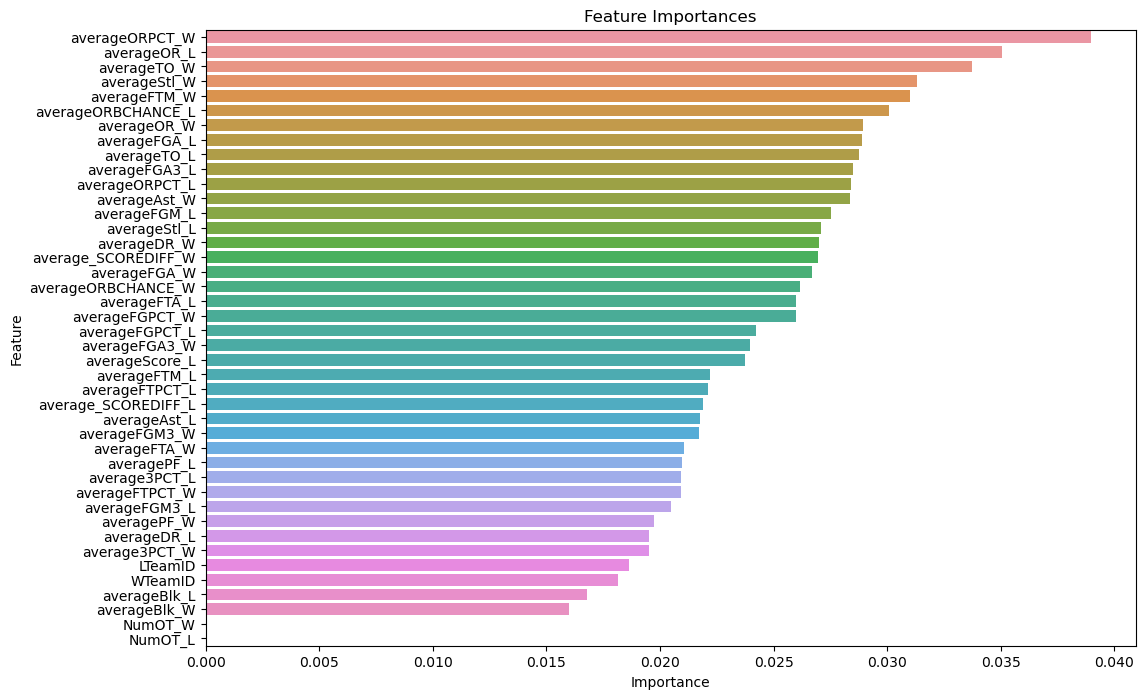

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from the best model
feature_importances = best_model.feature_importances_

# Create a dataframe to store feature importances with corresponding feature names
feature_importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': feature_importances})

# Sort the dataframe by feature importance values
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [40]:
# Convert the predicted values to a DataFrame
predictions_df = pd.DataFrame({'Actual_Outcome': y_test, 'Predicted_Outcome': y_pred})

# Display the predictions
print(predictions_df)

      Actual_Outcome  Predicted_Outcome
3703               1                  1
9792               0                  0
9821               0                  0
303                1                  1
4862               1                  1
...              ...                ...
7298               0                  0
6010               0                  0
6431               0                  0
2629               1                  1
8913               0                  0

[2243 rows x 2 columns]


In [41]:
import pandas as pd

# Assuming y_pred contains the model predictions for X_test
# and that WTeamID and LTeamID are part of the columns in X_test

# Create a DataFrame with WTeamID, LTeamID, and the predicted outcomes
df_predictions = pd.DataFrame({
    'WTeamID': X_test['WTeamID'],
    'LTeamID': X_test['LTeamID'],
    'PredictedOutcome': y_pred
})

# Display the first few rows of the predictions DataFrame
df_predictions


,WTeamID,LTeamID,PredictedOutcome
3703,1364,1167,1
9792,1267,1111,0
9821,1272,1317,0
303,1285,1413,1
4862,1438,1130,1
...,...,...,...
7298,1334,1413,0
6010,1259,1127,0
6431,1435,1301,0
2629,1136,1306,1


In [42]:
# THIS WORKS BUT TAKES A DIFFERENT AMOUNT OF ARGUMENTS THAN ARE USED WHEN IT IS CALLED IN SIMULATE TOURNEY

def get_predict_winner_df(row):
    if row['PredictedOutcome'] == 1:
        return row['WTeamID']
    else:
        return row['LTeamID']

# Apply the function to each row in df_predictions to get the winner's ID
df_predictions['WinnerTeamID'] = df_predictions.apply(get_predict_winner_df, axis=1)

# Display the DataFrame to verify the results
df_predictions


,WTeamID,LTeamID,PredictedOutcome,WinnerTeamID
3703,1364,1167,1,1364
9792,1267,1111,0,1111
9821,1272,1317,0,1317
303,1285,1413,1,1285
4862,1438,1130,1,1438
...,...,...,...,...
7298,1334,1413,0,1413
6010,1259,1127,0,1127
6431,1435,1301,0,1301
2629,1136,1306,1,1136


In [43]:
def predict_winner(strong_team_id, weak_team_id, predicted_winner_id):
    return predicted_winner_id

In [44]:
#winner_id = predict_winner(strong_team_id, weak_team_id, predicted_winner_id)


In [45]:
df_seeds #THESE ARE 2024 SEEDS

,Tournament,Seed,TeamID
0,M,W01,1163
1,M,W02,1235
2,M,W03,1228
3,M,W04,1120
4,M,W05,1361
...,...,...,...
123,W,Z12,3162
124,W,Z13,3267
125,W,Z14,3238
126,W,Z15,3263


In [46]:
df_seeds_male = df_seeds[df_seeds['Tournament'] == 'M']
df_seeds_male #THESE ARE 2024 SEEDS

,Tournament,Seed,TeamID
0,M,W01,1163
1,M,W02,1235
2,M,W03,1228
3,M,W04,1120
4,M,W05,1361
...,...,...,...
59,M,Z12,1241
60,M,Z13,1436
61,M,Z14,1324
62,M,Z15,1443


In [47]:

df_seeds_m = pd.merge(df_seeds_male, df_predictions, left_on='TeamID', right_on='WinnerTeamID', how='inner')

# Display the resulting DataFrame
df_seeds_m


,Tournament,Seed,TeamID,WTeamID,LTeamID,PredictedOutcome,WinnerTeamID
0,M,W01,1163,1163,1476,1,1163
1,M,W01,1163,1314,1163,0,1163
2,M,W01,1163,1163,1385,1,1163
3,M,W01,1163,1264,1163,0,1163
4,M,W01,1163,1163,1306,1,1163
...,...,...,...,...,...,...,...
566,M,Z16,1255,1454,1255,0,1255
567,M,Z16,1255,1126,1255,0,1255
568,M,Z16,1255,1421,1255,0,1255
569,M,Z16,1255,1255,1175,1,1255


In [48]:
# df_seeds_MNCAA = df_seeds_MNCAA[df_seeds_MNCAA['Season'] == 2023].copy()
# df_seeds_MNCAA

In [49]:
round_slots
# THIS WILL BE THE SAME AS IN 2024

,Season,Slot,StrongSeed,WeakSeed
2385,2023,R1W1,W01,W16
2386,2023,R1W2,W02,W15
2387,2023,R1W3,W03,W14
2388,2023,R1W4,W04,W13
2389,2023,R1W5,W05,W12
...,...,...,...,...
2443,2023,R4Y1,R3Y1,R3Y2
2444,2023,R4Z1,R3Z1,R3Z2
2445,2023,R5WX,R4W1,R4X1
2446,2023,R5YZ,R4Y1,R4Z1


In [50]:
# Perform a merge that combines seed information with match outcomes
# merged_df = pd.merge(df_seeds_male, df_predictions, left_on='TeamID', right_on='WinnerTeamID', how='left')

# # Drop duplicates based on TeamID to ensure each team is represented only once
# # This approach arbitrarily keeps the first win associated with each team, which may not match specific tournament logic
# unique_teams_df = merged_df.drop_duplicates(subset=['TeamID'])

# #unique_teams_df = unique_teams_df[['Tournament', 'Seed', 'TeamID', 'WinnerTeamID']]
# unique_teams_df

In [51]:
# Assuming df_seeds_male and df_predictions are your DataFrames
# You need to specify 'TeamID' from df_seeds_male to match 'WinnerTeamID' from df_predictions
#merged_df = pd.merge(df_predictions, df_seeds_male, left_on='WinnerTeamID', right_on='TeamID', how='left')

# Now merged_df contains columns from both df_predictions and df_seeds_male, merged on the winner's TeamID
#print(merged_df.head())


In [52]:
# # Calculate and merge Elo ratings for Men's
# #elo_df_m = calculate_elo_ratings(df_games[df_games['Season'] == 2024], 'M')
# # df_seeds_m = pd.merge(df_seeds_male, df_predictions, left_on='TeamID', right_on='WinnerTeamID', how='left')
# # df_seeds_m

# # Merge df_seeds_male with df_predictions to include only teams from df_seeds_male
# # This time, performing a right merge to ensure all rows from df_seeds_male are included
# df_seeds_m = pd.merge(df_predictions, df_seeds_male, left_on='WinnerTeamID', right_on='TeamID', how='right')

# # Since we're ensuring the merge retains all teams from df_seeds_male,
# # the resulting DataFrame will have 64 rows if each team from df_seeds_male has a corresponding winning entry in df_predictions.
# # If some teams did not win any matches according to df_predictions, those rows will still appear due to the 'right' merge,
# # but will have NaNs in the columns coming from df_predictions.


# df_seeds_m#.groupby('TeamID').sum()

In [53]:
#elo_df_m = calculate_elo_ratings(df_games_m[df_games_m['Season'] == 2024], 'M')
#df_seeds_m = merge_elo_with_seeds(df_seeds[df_seeds['Tournament'] == 'M'], elo_df_m)

In [54]:
# elo_df_w = calculate_elo_ratings(df_games_w[df_games_w['Season'] == 2024], 'W')
# df_seeds_w = merge_elo_with_seeds(df_seeds[df_seeds['Tournament'] == 'W'], elo_df_w)

In [55]:
#df_seeds_w

# trying: game unit of observation with season avg stats

# XGBoost

# WHICH 64 TEAMS PLAY IN THE TOURNAMENT?

In [56]:
# These 64 TeamIDs are in the tournament
df_seeds_male

,Tournament,Seed,TeamID
0,M,W01,1163
1,M,W02,1235
2,M,W03,1228
3,M,W04,1120
4,M,W05,1361
...,...,...,...
59,M,Z12,1241
60,M,Z13,1436
61,M,Z14,1324
62,M,Z15,1443


In [57]:
df_24

,Season,TeamID,averageScore,averageFGM,averageFGA,averageFGM3,averageFGA3,averageFTM,averageFTA,averageOR,...,averageTO,averageStl,averageBlk,averagePF,averageFGPCT,average3PCT,averageFTPCT,averageORBCHANCE,averageORPCT,average_SCOREDIFF
7247,2024,1101,71.424370,24.850840,57.981092,5.090336,14.716387,16.632353,22.567227,7.760504,...,12.094538,7.886555,2.113445,19.649160,0.431314,0.348841,0.740826,33.342437,0.234262,9.445378
7248,2024,1102,68.477273,24.106061,52.244949,8.994949,24.361111,11.270202,16.376263,6.229798,...,10.424242,6.790404,4.315657,17.219697,0.460484,0.368758,0.687598,27.916667,0.221374,12.974747
7249,2024,1103,70.450000,24.809091,55.459091,7.254545,23.104545,13.577273,18.627273,7.972727,...,11.000000,5.168182,2.827273,17.004545,0.446565,0.319053,0.735653,30.013636,0.262791,8.677273
7250,2024,1104,88.536797,30.106061,64.549784,10.376623,30.041126,17.948052,23.095238,10.915584,...,12.008658,6.735931,3.787879,20.965368,0.468108,0.342506,0.771090,33.512987,0.324385,17.077922
7251,2024,1105,69.363636,22.954545,54.500000,4.204545,14.522727,19.250000,26.568182,9.659091,...,14.977273,7.681818,4.000000,20.454545,0.423166,0.289944,0.719939,31.772727,0.304636,11.795455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7604,2024,1474,78.322368,27.096491,62.390351,8.618421,25.528509,15.510965,21.528509,8.480263,...,11.019737,6.695175,2.747807,17.506579,0.436011,0.337942,0.715889,34.175439,0.242721,11.359649
7605,2024,1475,70.520833,22.941667,53.512500,7.141667,19.675000,17.495833,23.300000,7.975000,...,12.420833,5.845833,2.300000,20.820833,0.434243,0.370589,0.752429,30.187500,0.261532,9.687500
7606,2024,1476,64.740741,23.111111,53.666667,8.111111,24.444444,10.407407,15.574074,6.185185,...,11.648148,5.407407,2.648148,15.111111,0.438255,0.341948,0.670147,30.425926,0.195134,13.703704
7607,2024,1477,70.675000,24.250000,60.000000,8.575000,27.400000,13.600000,19.625000,7.525000,...,10.600000,7.400000,4.725000,17.575000,0.404911,0.310385,0.703995,34.675000,0.214094,12.100000


In [58]:
tourny_teams_df = pd.merge(df_seeds_male, df_24, on='TeamID', how='inner')
tourny_teams_df

,Tournament,Seed,TeamID,Season,averageScore,averageFGM,averageFGA,averageFGM3,averageFGA3,averageFTM,...,averageTO,averageStl,averageBlk,averagePF,averageFGPCT,average3PCT,averageFTPCT,averageORBCHANCE,averageORPCT,average_SCOREDIFF
0,M,W01,1163,2024,73.430108,26.639785,58.204301,7.532258,22.930108,12.618280,...,9.666667,5.225806,4.306452,17.182796,0.457650,0.315877,0.758265,29.946237,0.364375,16.301075
1,M,W02,1235,2024,71.753968,25.611111,57.682540,6.227513,18.833333,14.304233,...,11.187831,9.325397,2.931217,17.513228,0.444055,0.330360,0.678659,31.746032,0.305695,13.748677
2,M,W03,1228,2024,81.975962,27.980769,62.504808,8.427885,24.403846,17.586538,...,10.625000,4.500000,3.519231,16.139423,0.449144,0.348723,0.762002,33.706731,0.341127,10.865385
3,M,W04,1120,2024,78.230159,27.145503,60.677249,7.119048,22.605820,16.820106,...,10.886243,7.047619,5.917989,19.711640,0.446324,0.316658,0.727026,33.193122,0.302996,14.666667
4,M,W05,1361,2024,72.227273,25.150000,58.509091,6.740909,22.286364,15.186364,...,10.531818,7.181818,3.800000,18.259091,0.431014,0.301587,0.740728,32.286364,0.296573,9.631818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,M,Z12,1241,2024,75.933333,28.300000,64.933333,6.416667,20.716667,12.916667,...,10.700000,9.333333,2.633333,18.766667,0.437937,0.296341,0.721424,35.116667,0.300110,11.083333
60,M,Z13,1436,2024,68.032051,24.544872,55.839744,8.147436,24.878205,10.794872,...,9.057692,4.865385,3.192308,14.429487,0.441803,0.325507,0.667517,31.858974,0.193872,9.320513
61,M,Z14,1324,2024,74.667984,26.626482,60.507905,8.507905,25.324111,12.907115,...,10.986166,6.592885,2.703557,15.160079,0.443181,0.336762,0.756355,32.685771,0.284025,11.792490
62,M,Z15,1443,2024,78.351675,28.825359,62.198565,6.397129,19.234450,14.303828,...,13.435407,7.610048,3.074163,19.081340,0.466476,0.326301,0.711239,32.643541,0.258599,7.763158


# START HERE

1) WE NEED TO create the 64 teams with their average stats, seed, teamID, Tournament (like his df_seeds_m)

2) We need to change his simulate_tournament to grab the features from the two teams playing each other and than predict a winner. Then we will call model.predict like our sudo code

3) Once we have a tournament simulated we need to add in the slots.


In [59]:
# def simulate_tournament(seeds_df, slots_df):
#     slot_winners = {}   # Initialize a dictionary to store winners of each slot
#     for _, row in slots_df.iterrows():
#         slot = row['Slot'] # Identify the current slot
        
#         # Round 1 uses direct seeds; subsequent rounds use winners from previous rounds
#         if row['Slot'].startswith('R1'):
#             strong_team_seed = row['StrongSeed']
#             weak_team_seed = row['WeakSeed']
#         else:
#             strong_team_seed = slot_winners.get(row['StrongSeed'])
#             weak_team_seed = slot_winners.get(row['WeakSeed'])

#         # Get team IDs and predict the winner
#         strong_team_id = seeds_df.loc[seeds_df['Seed'] == strong_team_seed, 'TeamID'].iloc[0]
#         weak_team_id = seeds_df.loc[seeds_df['Seed'] == weak_team_seed, 'TeamID'].iloc[0]
#         winner_id = predict_winner(strong_team_id, weak_team_id, seeds_df)
#         winner_seed = seeds_df.loc[seeds_df['TeamID'] == winner_id, 'Seed'].iloc[0]
#         slot_winners[slot] = winner_seed

#     return slot_winners

In [60]:
# def prepare_input_data(strong_team_id, weak_team_id, df):
#     # Select rows corresponding to the strong and weak teams
#     strong_team_data = df[df['TeamID'] == strong_team_id]
#     weak_team_data = df[df['TeamID'] == weak_team_id]
    
#     # Drop the 'TeamID' column as it is not needed for prediction
#     strong_team_data = strong_team_data.drop(columns=['TeamID'])
#     weak_team_data = weak_team_data.drop(columns=['TeamID'])
    
#     # Rename columns to distinguish between strong and weak teams
#     strong_team_data = strong_team_data.add_suffix('_strong')
#     weak_team_data = weak_team_data.add_suffix('_weak')
    
#     # Combine the data for strong and weak teams into a single row
#     input_data = pd.concat([strong_team_data.reset_index(drop=True), weak_team_data.reset_index(drop=True)], axis=1)
    
#     return input_data


In [61]:
def simulate_tournament(seeds_df, slots_df):
    slot_winners = {}   # Initialize a dictionary to store winners of each slot
    for _, row in slots_df.iterrows():
        slot = row['Slot'] # Identify the current slot
        
        # Round 1 uses direct seeds; subsequent rounds use winners from previous rounds
        if row['Slot'].startswith('R1'):
            strong_team_seed = row['StrongSeed']
            weak_team_seed = row['WeakSeed']
        else:
            strong_team_seed = slot_winners.get(row['StrongSeed'])
            weak_team_seed = slot_winners.get(row['WeakSeed'])

        # Get team IDs and predict the winner
        strong_team_id = seeds_df.loc[seeds_df['Seed'] == strong_team_seed, 'TeamID'].iloc[0]
        weak_team_id = seeds_df.loc[seeds_df['Seed'] == weak_team_seed, 'TeamID'].iloc[0]
        predicted_winner_id = seeds_df.loc[seeds_df['Seed'] == strong_team_seed, 'WinnerTeamID'].iloc[0]
        winner_id = predict_winner(strong_team_id, weak_team_id, predicted_winner_id)
        winner_seed = seeds_df.loc[seeds_df['TeamID'] == winner_id, 'Seed'].iloc[0]
        slot_winners[slot] = winner_seed

    return slot_winners


In [62]:
def prepare_submission_data(winners, tournament_type, start_row_id=1):
    submission_data = []
    row_id = start_row_id

    for slot, winner_seed in winners.items():
        game_data = {
            'RowId': row_id,
            'Tournament': tournament_type,
            'Bracket': 1,  # Assuming a single bracket simulation
            'Slot': slot,
            'Team': winner_seed
        }
        submission_data.append(game_data)
        row_id += 1

    return submission_data, row_id 

## Run 2 trying to fix overfitting

In [63]:
def calculate_elo_ratings(games_df, tournament_type):
  
    team_ratings = {team: 1500 for team in set(games_df['WTeamID']).union(games_df['LTeamID'])}
    for _, row in games_df.iterrows():
        w_rating, l_rating = team_ratings[row['WTeamID']], team_ratings[row['LTeamID']]
        team_ratings[row['WTeamID']], team_ratings[row['LTeamID']] = update_elo(w_rating, l_rating)
    
    return pd.DataFrame(list(team_ratings.items()), columns=['TeamID', 'EloRating'])

In [64]:
def merge_elo_with_seeds(seeds_df, elo_df):
    
    seeds_df = seeds_df.copy()
    seeds_df['TeamID'] = seeds_df['TeamID'].astype(int)
    return pd.merge(seeds_df, elo_df, on='TeamID', how='left')

# Simulating Tournament

In [65]:
men_winners = simulate_tournament(df_seeds_m, round_slots)
#women_winners = simulate_tournament(df_seeds_w, round_slots_w)

In [66]:
# Start with RowId 1 for Men's tournament
men_submission_data, next_row_id = prepare_submission_data(men_winners, 'M', 1)

# Continue with the next RowId for Women's tournament
#women_submission_data, _ = prepare_submission_data(women_winners, 'W', next_row_id)

# Combine Men's and Women's submission data
#combined_submission_data = men_submission_data + women_submission_data


# Converting to DF

In [67]:
# Convert to DataFrame
df_submission = pd.DataFrame(men_submission_data)
#df_submission.to_csv('submission.csv', index=False)

In [68]:
df_submission

,RowId,Tournament,Bracket,Slot,Team
0,1,M,1,R1W1,W01
1,2,M,1,R1W2,W02
2,3,M,1,R1W3,W03
3,4,M,1,R1W4,W04
4,5,M,1,R1W5,W05
...,...,...,...,...,...
58,59,M,1,R4Y1,Y01
59,60,M,1,R4Z1,Z01
60,61,M,1,R5WX,W01
61,62,M,1,R5YZ,Y01


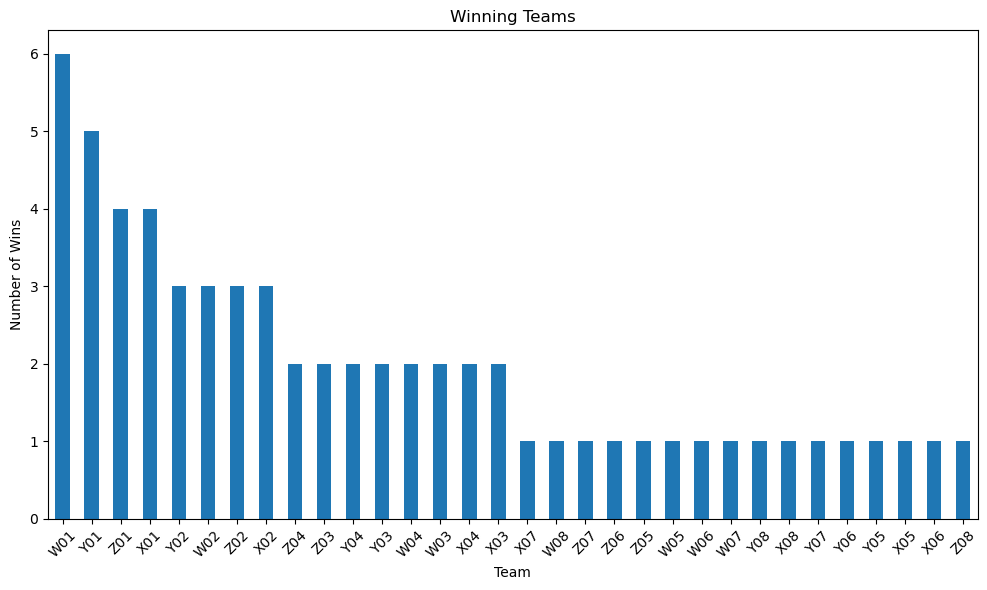

In [69]:
import matplotlib.pyplot as plt

# Group the DataFrame by Team and count the occurrences of each team
winning_teams_counts = df_submission['Team'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
winning_teams_counts.plot(kind='bar')
plt.title('Winning Teams')
plt.xlabel('Team')
plt.ylabel('Number of Wins')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [70]:
# Assuming tourny_teams_df is your DataFrame containing tournament teams information
team_W01_ID = tourny_teams_df[tourny_teams_df['Seed'] == 'W01']['TeamID'].values[0]

# Print the row where Seed is 'Y01'
team_W01_ID


1163

In [71]:
# Assuming tourny_teams_df is your DataFrame containing tournament teams information
team_Y01_ID = tourny_teams_df[tourny_teams_df['Seed'] == 'Y01']['TeamID'].values[0]

# Print the row where Seed is 'Y01'
team_Y01_ID

1345

In [72]:
champion_team_name =  mteams_df[mteams_df['TeamID'] == team_W01_ID]['TeamName'].values[0]
runner_up_team_name = mteams_df[mteams_df['TeamID'] == team_Y01_ID]['TeamName'].values[0]

print(f"Predicted Champ: {champion_team_name}")
print(f"Predicted Runner Up: {runner_up_team_name}")

Predicted Champ: Connecticut
Predicted Runner Up: Purdue
